## **Obrada signala** - Prvi projektni zadatak (2025/26)
Izradio: ***Andrija Adamović***

### **1. Dio**: Snimanje i osnovna analiza

In [1]:
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, iirpeak, tf2sos, sosfilt, lfilter
from scipy.interpolate import PchipInterpolator
import phonlab as phon

#Ucitavanje .wav datoteka iz foldera audio_folder/
def load_sound(rel_path : str, vowels: list, duration):
    paths = [rel_path + v + ".wav" for v in vowels]
    
    data = []
    f_s = 0
    for i in range(len(vowels)):
        rdata, fs = phon.loadsig(paths[i], fs=None, duration=duration)

        data.append(rdata)
        f_s = fs
    data = np.array(data)
    return (data, f_s)

vowels = ['a', 'e', 'i', 'o', 'u']
sound_duration = 1.5 #1.5 sekundi

#Na MS Windowsima promjeniti u "audio_folder\"
data, fs = load_sound("audio_folder/", vowels, sound_duration)

**Glas A**

In [2]:
Audio(data=data[0], rate=fs)

**Glas E**

In [3]:
Audio(data=data[1], rate=fs)

**Glas I**

In [4]:
Audio(data=data[2], rate=fs)

**Glas O**

In [5]:
Audio(data=data[3], rate=fs)

**Glas U**

In [6]:
Audio(data=data[4], rate=fs)

Valni oblici samoglasnika na cijeloj duljini zvuka

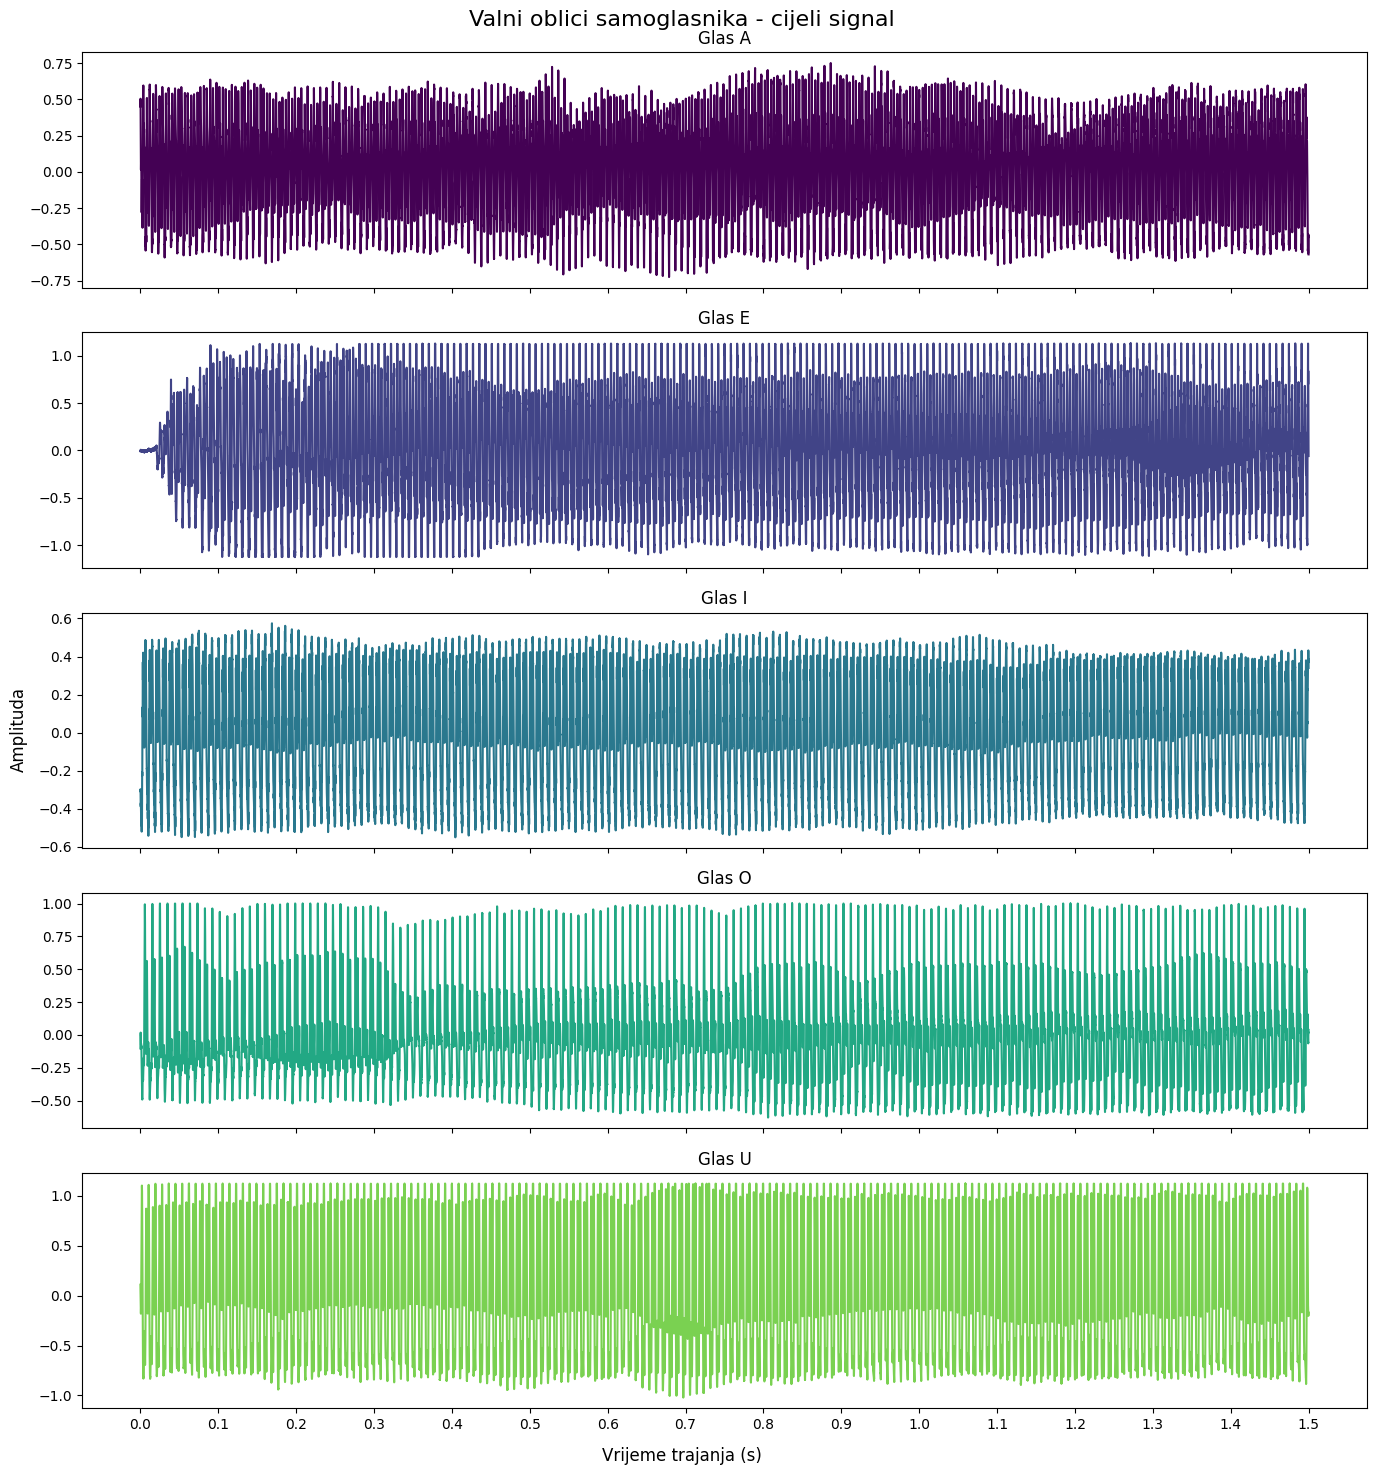

In [7]:
def plot_sounds(data, title :str, n=5, time_ax = None , xticks = None, figsize=(14, 15)):
    
    if time_ax is None:
        time_ax = np.linspace(0, len(data[0]), len(data[0]))/fs
    
    if xticks is None: 
        xticks = np.arange(0, sound_duration + 1e-10, 0.1)

    fig,ax = plt.subplots(n, sharex=True, figsize=figsize)
    ax = np.atleast_1d(ax)
    colors = plt.cm.viridis([0, 0.2, 0.4, 0.6, 0.8])

    fig.suptitle(title, fontsize=16)
    fig.supxlabel("Vrijeme trajanja (s)")
    fig.supylabel("Amplituda")

    for i in range(n):
        ax[i].plot(time_ax, data[i], color=colors[i])
        ax[i].set_title(f"Glas {vowels[i].capitalize()}")
        ax[i].set_xticks(xticks)

    plt.tight_layout()
    plt.show()

plot_sounds(data, n=5, title="Valni oblici samoglasnika - cijeli signal")

Valni oblici na kratkom isječku signala iz sredine (30 ms) - preglednije

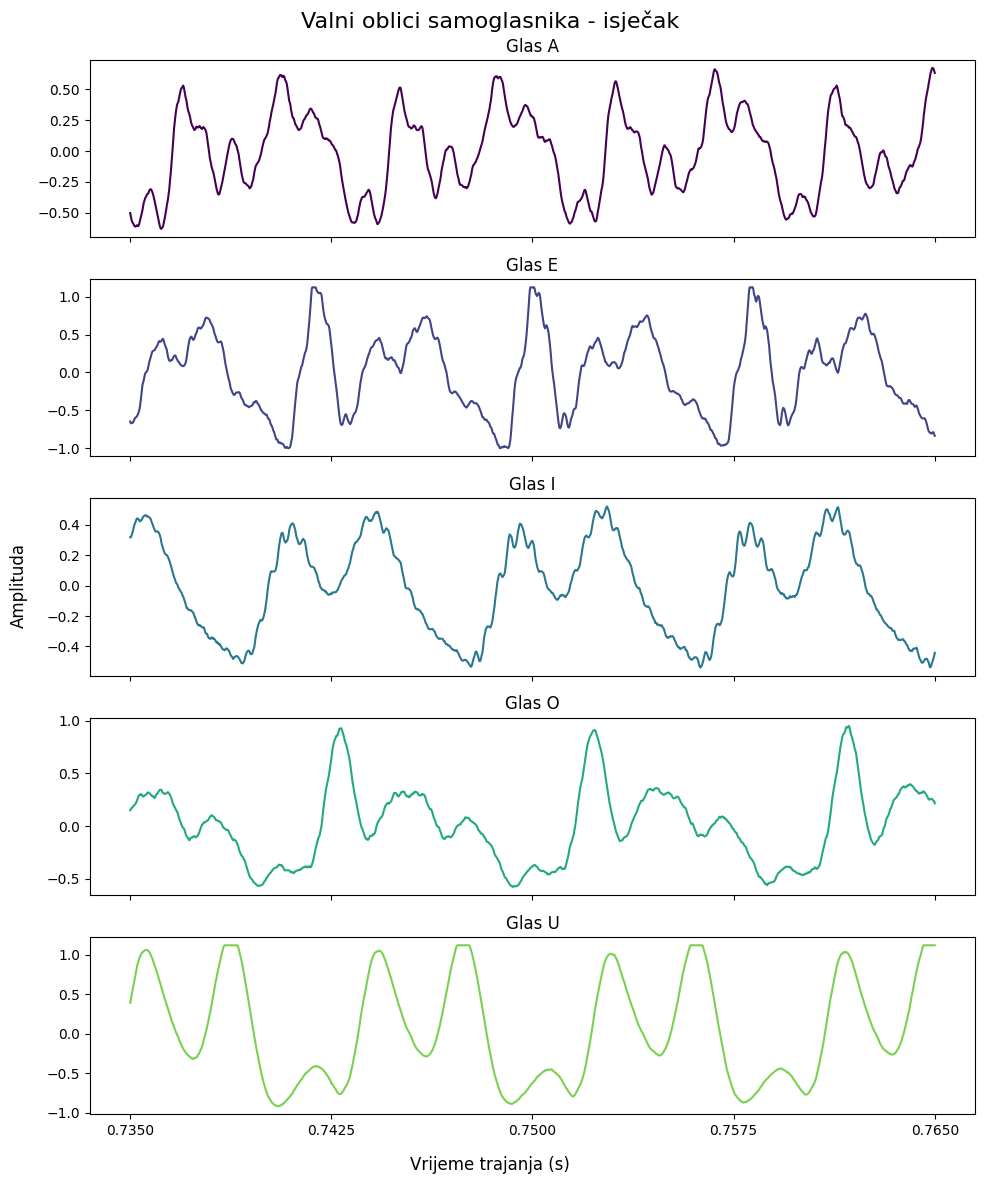

In [8]:
def sample_middle(data, T_span):
    if T_span > sound_duration / 2:
        raise ValueError("Out of range")
    
    middle = int(np.shape(data)[1]/2)
    N_samples = int(T_span * fs)
    Tmd = middle / fs

    mid_data = data[:, middle-N_samples//2:middle + N_samples//2]

    time_ax = np.linspace(Tmd - T_span/2, Tmd + T_span/2, len(mid_data[0]))
    xticks = np.arange(Tmd - T_span/2, Tmd + T_span/2 + 1e-10, T_span/4)

    return mid_data, time_ax, xticks

(short_data, t_ax, xtcks) = sample_middle(data, T_span=0.03)
plot_sounds(short_data, title="Valni oblici samoglasnika - isječak", time_ax=t_ax, xticks=xtcks, figsize=(10, 12))


Fourierovi spektri samoglasnika (frekv. ide do 4kHz jer više frekv. imaju zanemarivu energiju tj. amplitudu)

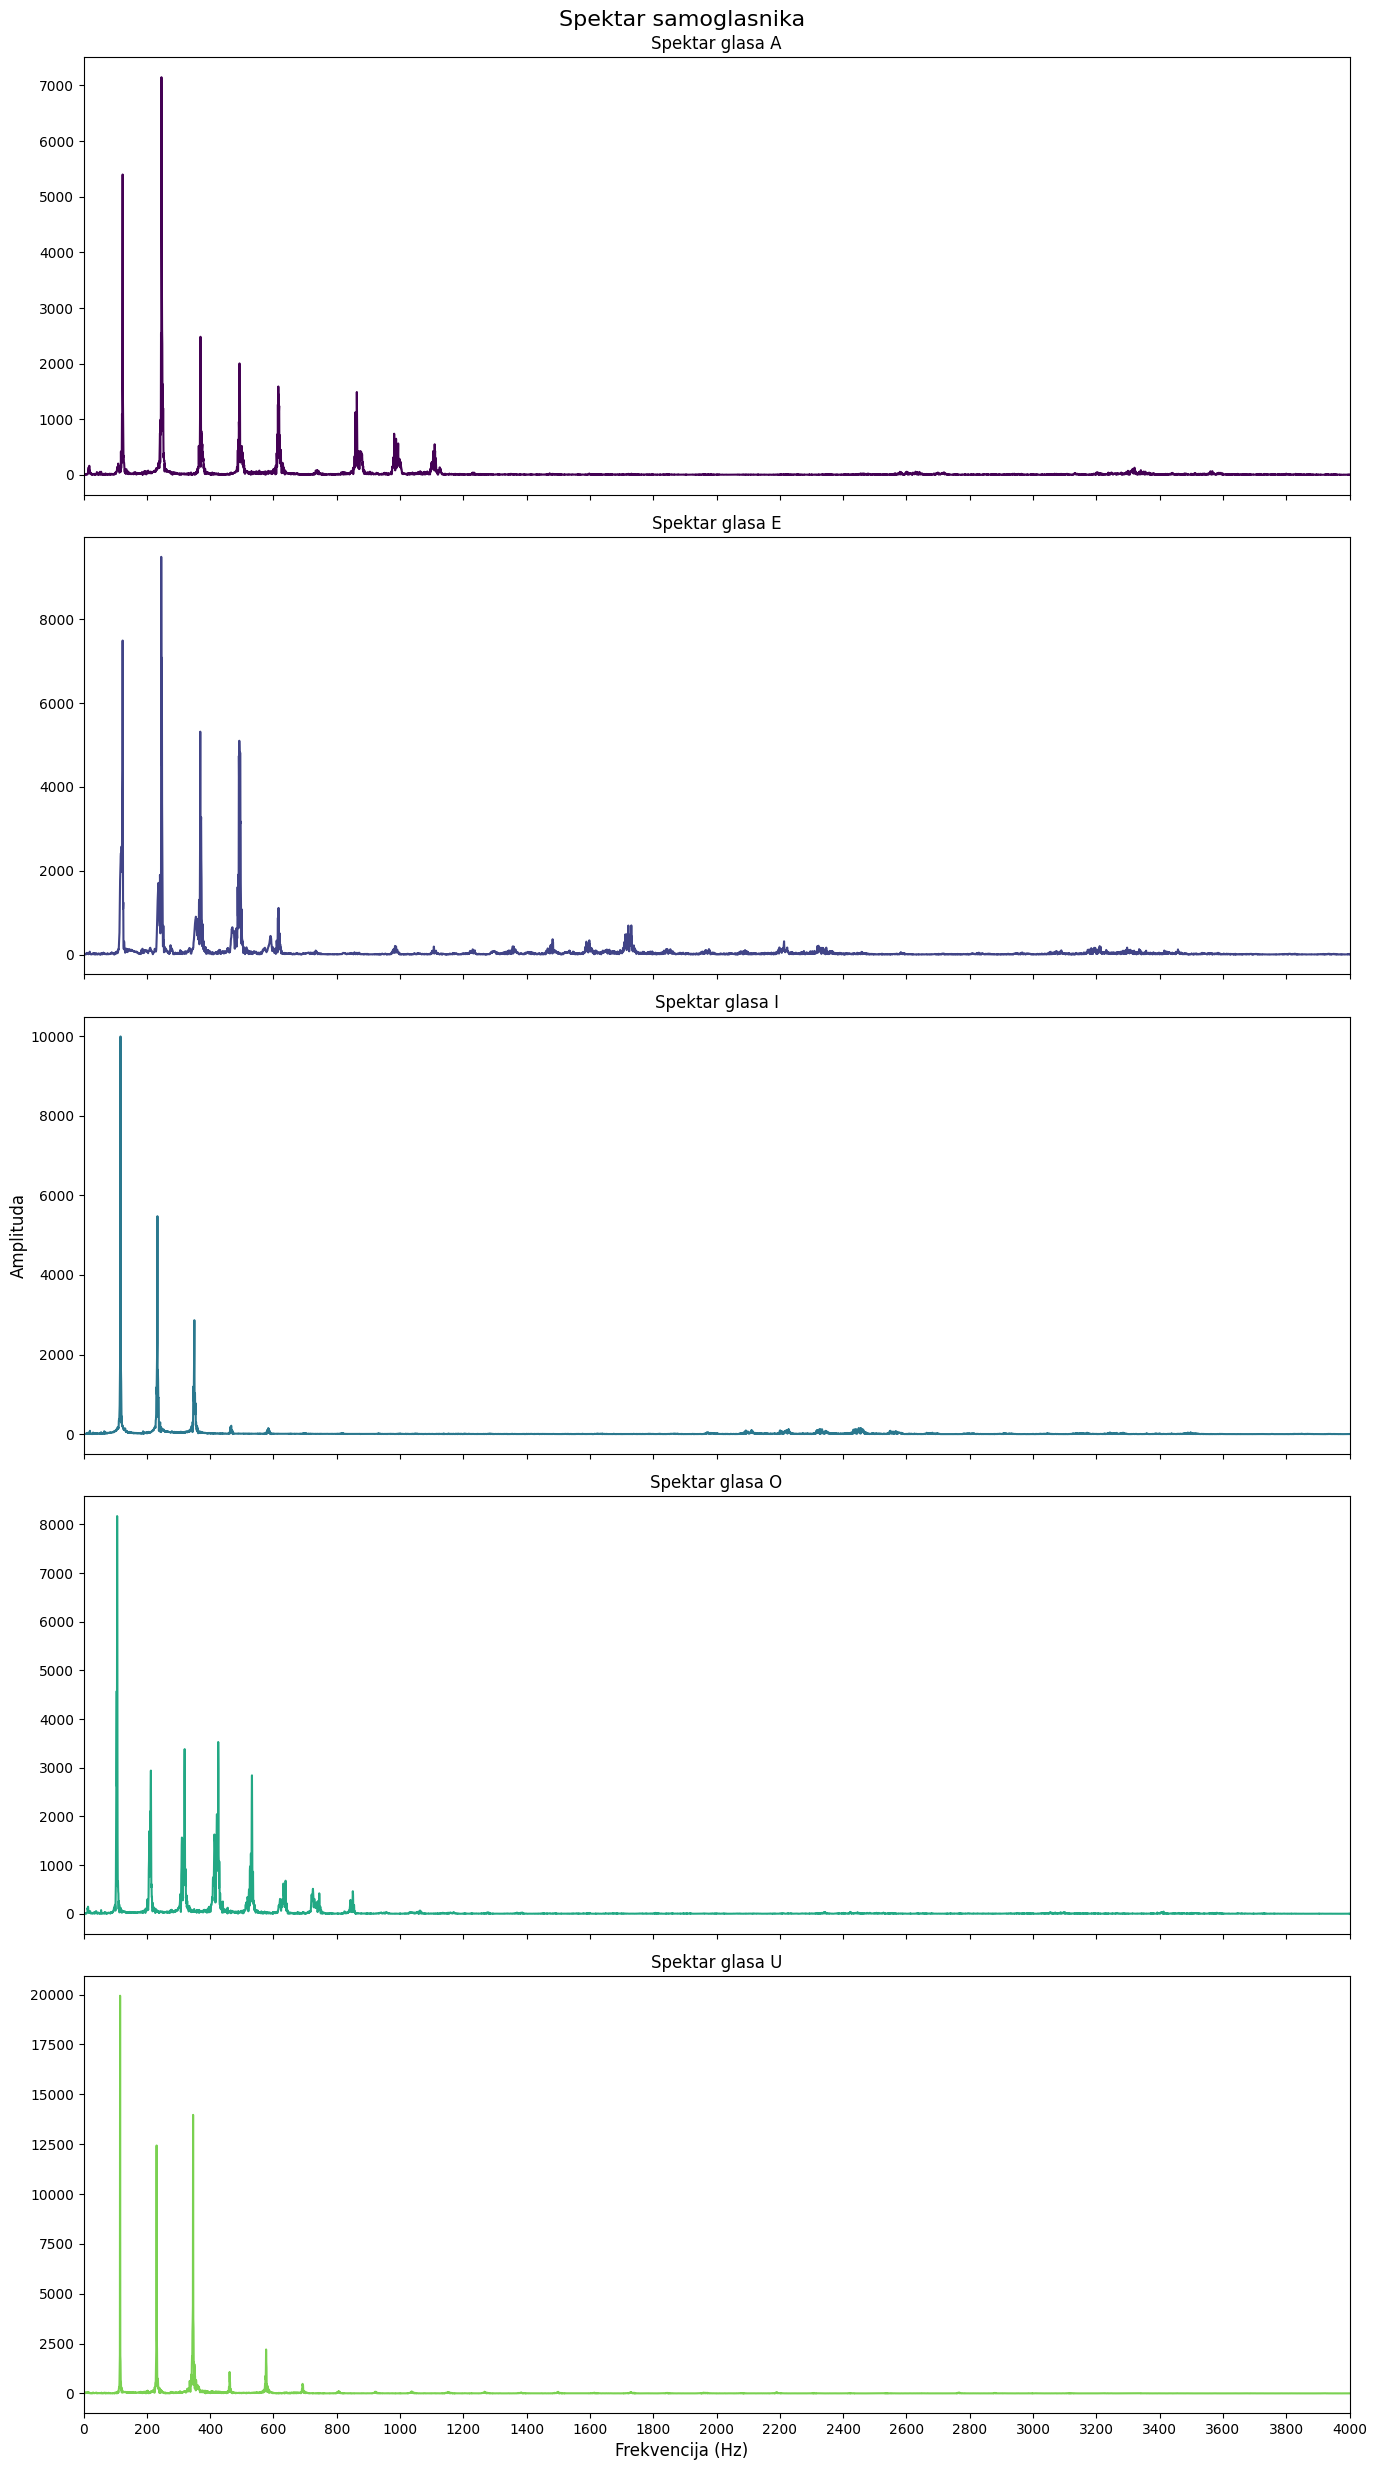

In [9]:
spectrum_ampl = np.abs(np.fft.rfft(data))

def graph_fft(fft_data, n=5, dB=False, f_max = 4000, figsize = (14, 25), sharex=True):
    fig,ax = plt.subplots(n, sharex=sharex, figsize=figsize)
    ax = np.atleast_1d(ax)
    colors = plt.cm.viridis([0, 0.2, 0.4, 0.6, 0.8])

    fig.suptitle("Spektar samoglasnika", fontsize=16, y=0.99)
    fig.supxlabel("Frekvencija (Hz)")
    fig.supylabel("Log-Amplituda (dB)") if dB else fig.supylabel("Amplituda")

    freqs = np.linspace(0.,fs/2 , np.shape(fft_data)[1]) 
    xticks = np.linspace(0, f_max, 21)
    for i in range(n):
        ax[i].plot(freqs, 20*np.log10(fft_data[i]) if dB else fft_data[i], color=colors[i])
        ax[i].set_xticks(xticks)
        ax[i].set_title(f"Spektar glasa {vowels[i].capitalize()}")
        ax[i].set_xlim(0, f_max)
    plt.tight_layout()
    plt.show()

#dB - prikaz amplitude u decibelima
graph_fft(spectrum_ampl, dB=False, f_max=4000)

### **2. Dio**: Pronalaženje formanta
Obzirom da samim promatranjem spektra svakog samoglasnika nije moguće jasno odrediti formante zbog njihove manje amplitude i veće širine te zbog prevladavanja osnovne frekvencije i njenih harmonika, signal je potrebno prilagoditi (filtrirati) te analizirati dodatnim metodama.

### Filtriranje s tzv. filterom za prednaglašavanje (pre-emphasis filter)
Koristimo taj filter kako bi pojačali više frekvencije u ljudskom glasu za bolje razlikovanje od šuma tj. poboljšavanje omjera signala i šuma (SNR - Signal-to-noise ratio). 

Definira se kao FIR filtar duljine 2 na sljedeći način
$$ z_n = x_n - \alpha x_{n-1}$$
Gdje $$ \alpha \in [0.9, 1] $$ 

Uzeta je vrijednost 0.97, pa filter glasi
$$ z_n = x_n - 0.97x_{n-1}$$

Frekvencijski odziv je tada
$$ |\lambda_s(\omega)| = |1-0.97e^{-i\omega}|  $$

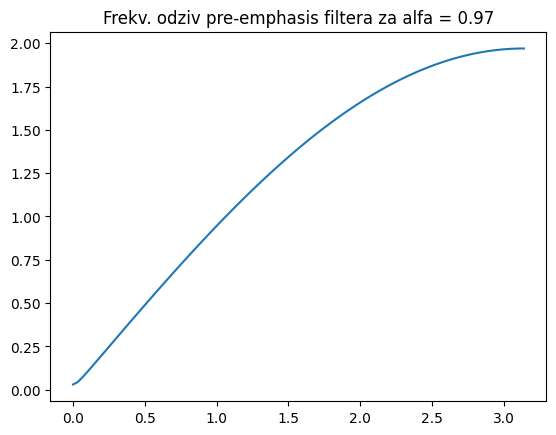

In [10]:
def freq_resp_preempfilt(alpha):
    omega = np.linspace(0, np.pi, 100)
    plt.plot(omega, np.abs(1 - alpha*np.exp(-1j*omega)))
    plt.title(f"Frekv. odziv pre-emphasis filtera za alfa = {alpha}")

freq_resp_preempfilt(alpha=0.97)

Iz frekvencijskog odziva jasno se radi o visoko-propusnom filtru (također se može vidjeti iz koeficijenata filtera jer predznaci alterniraju)

Primjena filtera na glasove

In [11]:
alpha = 0.97
data_filt = np.zeros_like(data)
data_filt[:, 0] = data[:, 0]
data_filt[:, 1:] = data[:, 1:] - alpha*data[:, :-1]

Filtrirani glas A

In [12]:
Audio(data=data_filt[0], rate=fs)

### Prozoriranje (windowing) isječka Hanningovim prozorom
Uzima se kratki isječak (30-60 ms) zvuka za analizu formanata jer na cijelom signalu postoje male promjene u intonaciji i izgovoru koje su nepovoljne za analizu. Prozoriranjem se utjecaj "rezanja" signala smanjuje tako što na rubovima smanji amplitudu time se uklanja pojava tzv. spektralnog curenja (spectral leakage), a u sredini je signal praktički netaknut.

Hanningov prozor duljine M:
$$ w_n = \frac{1}{2}-\frac{1}{2}\cos{(\frac{2\pi n}{M-1})} \ \ \ 0 \leq n \leq M-1 $$

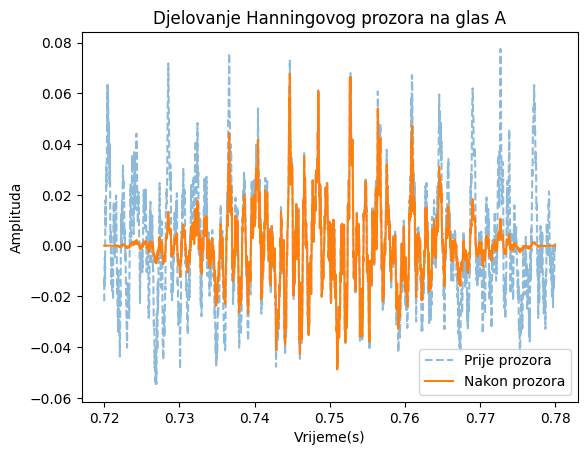

In [13]:
T_samp = 0.06 #60 milisekundi
(data_filt_short,t_ax_60,_) = sample_middle(data_filt, T_span=T_samp)

data_proc = data_filt_short * np.hanning(np.shape(data_filt_short)[1])

plt.title("Djelovanje Hanningovog prozora na glas A")
plt.plot(t_ax_60, data_filt_short[0], "--", alpha=0.5)
plt.plot(t_ax_60, data_proc[0])
plt.legend(["Prije prozora", "Nakon prozora"])
plt.xlabel("Vrijeme(s)")
plt.ylabel("Amplituda")
plt.show()


Prikaz spektra isjecka glasa A nakon filtriranja i prozoriranja

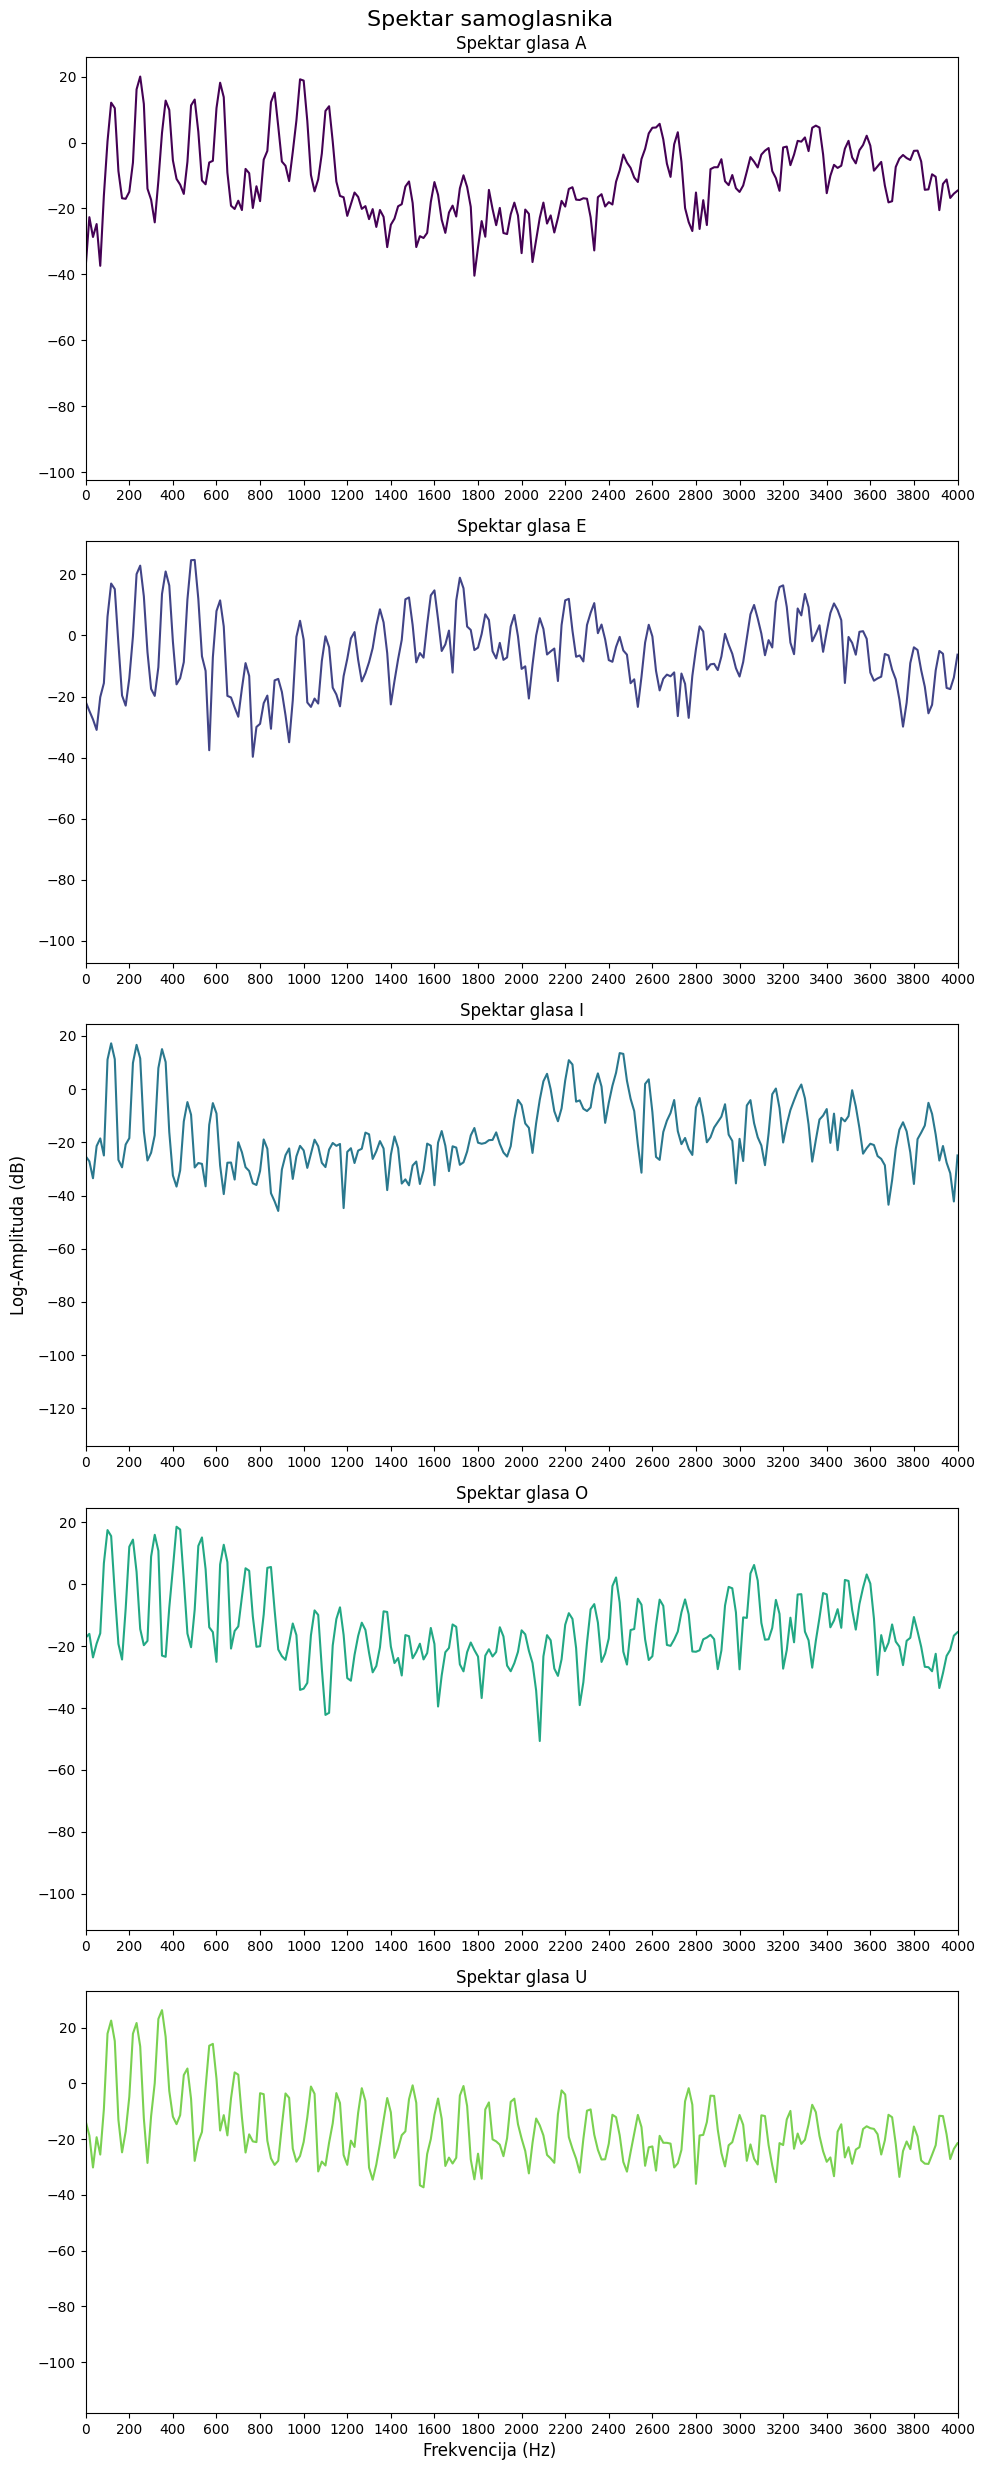

In [14]:
graph_fft(np.abs(np.fft.rfft(data_proc)),dB=True, n=5, f_max=4000, figsize=(10,25), sharex=False)

Analizom lokalnih maksimuma ovih spektara kao prvi maksimum se gotovo uvijek pojavljuje frekvencija oko 116Hz, to je osnovna frekvencija glasa f0. Ispod se nalazi lista osnovnih frekvencija za svaki samoglasnik.

In [15]:

def find_f0(sig_data):
    f0 = []
    for i in range(np.shape(sig_data)[0]):
        spec = 20*np.log10(np.abs(np.fft.rfft(sig_data[i])))
        peaks, _ = find_peaks(spec, height=-5) #frekvencije lokalnih maksimuma (amplituda > 1)
        f0.append(peaks[0] *  ((fs/2) / len(spec)))
    return np.array(f0)

f0_list = np.round(find_f0(data_proc), 2)
print(f"Frekvencije f_0 za samoglasnike: {f0_list}")
print(f"Prosječni f0: {np.round(np.average(f0_list), 2)} Hz")


Frekvencije f_0 za samoglasnike: [116.58 116.58 116.58  99.92 116.58]
Prosječni f0: 113.25 Hz


Frekvencija f0 i njene harmonike otežavaju traženje formanata. Sljedeća funkcija miče frekvenciju f0 i njenu prvu harmoniku iz popisa lokalnih maksimuma. 

In [16]:
def remove_f0_harm(sig_data, vowel_indx):
    peak_freqs = []
    peak_vals = []

    spec = 20*np.log10(np.abs(np.fft.rfft(sig_data[vowel_indx])))
    spec_freqs = np.linspace(0.,fs/2 , len(spec))
    peaks_index, _ = find_peaks(spec, height=-4)
    peak_freqs = peaks_index * ((fs/2) / len(spec))
    peak_vals = spec[peaks_index]
        
    return (np.array([peaks_index[2:],peak_freqs[2:], peak_vals[2:]]), spec, spec_freqs)

Sljedeća funkcija računa interpolacijski splajn između (dovoljno visokih) maksimuma u spektru. Za splajn se koristi PCHIP - Piecewise Cubic Hermite Interpolating Polynomial jer on nema velike skokove na rubovima intervala. Interpolacija je samo između značajnih maksimuma. Tom interpolacijom dobije se **grubi prikaz** tzv. spektralne omotnice (spectral envelope) između vrhova, točniji prikaz se može dobiti (npr. Linear predictive coding metoda) - literatura.

In [17]:
def peak_interp_spline(sig_data, n=5):
    indices, splines = [],[]
    spectrum = []
    spectrum_freq_list = []
    for i in range(n):
        peaks, spec, spec_freqs = remove_f0_harm(sig_data, vowel_indx=i)

        #Dodano ishodiste kao prva tocka interpolacije - estetski razlozi
        peaks = np.column_stack((np.zeros((3,1)), peaks))

        spectrum.append(spec)
        spectrum_freq_list = spec_freqs
        spline = PchipInterpolator(x=peaks[1], y=peaks[2], )
        indices.append(np.int16(peaks[0]))
        splines.append(spline)
    return (splines, indices, spectrum, spectrum_freq_list)

def graph_interp_spline(sig_data, vowel='a'):
    spline, indices, spectrum, freqs = peak_interp_spline(sig_data, n=5)
    vows = {'a':0, 'e':1, 'i':2, 'o':3, 'u':4}

    vow = vows[vowel]
    plt.figure(figsize=(12,3))
    plt.plot(freqs[indices[vow][0]: indices[vow][-1]+5], spline[vow](freqs[indices[vow][0]: indices[vow][-1]+5]), color='orange')

    plt.xlim(0, 4000)
    plt.xticks(np.arange(0, 4000+1e-12, 200))

    plt.plot(freqs, spectrum[vow], '--', color="purple")

    plt.title(f"Spektar slova {vowel.capitalize()} sa interp. splajnom")
    plt.xlabel("Frekvencija [Hz]")
    plt.ylabel("Log-Amplituda [dB]")
    plt.grid("on")
    plt.show()

Prikaz interpolacijskog splajna na spektru slova A - spektralna omotnica

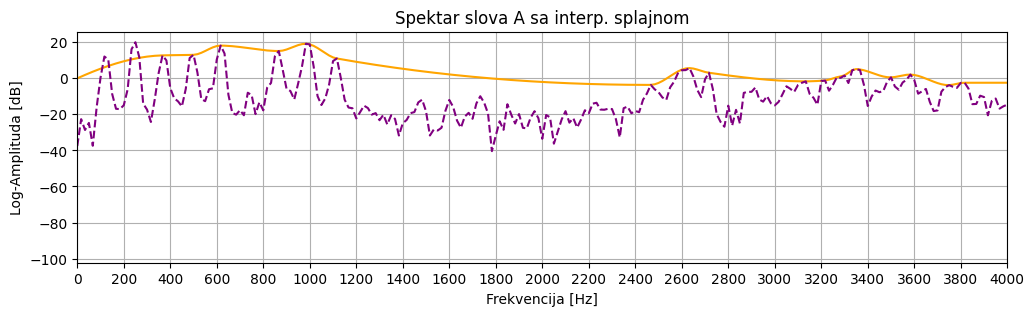

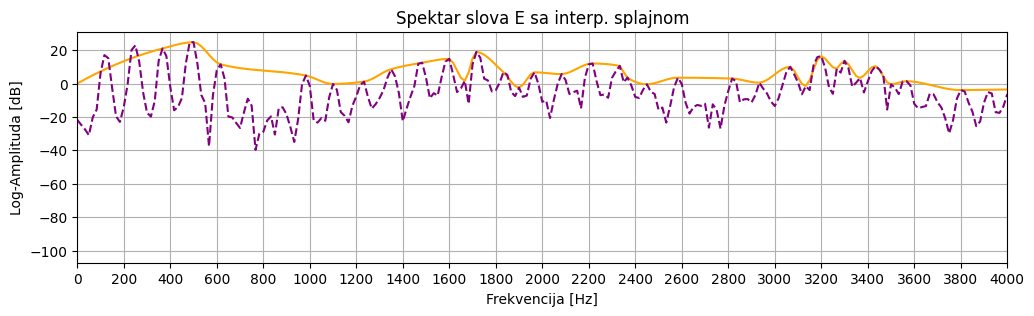

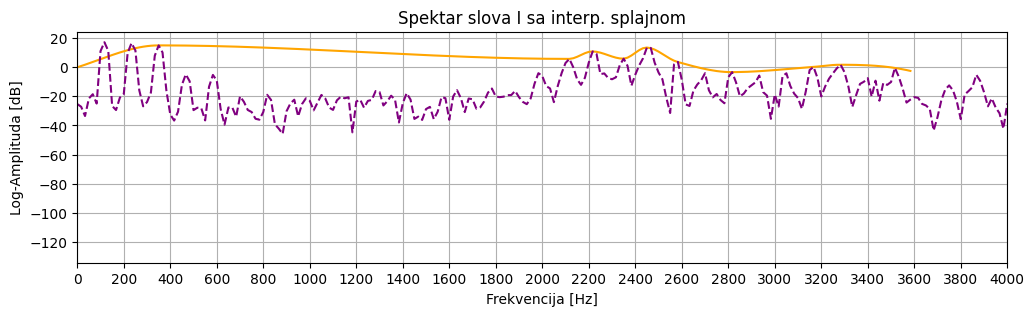

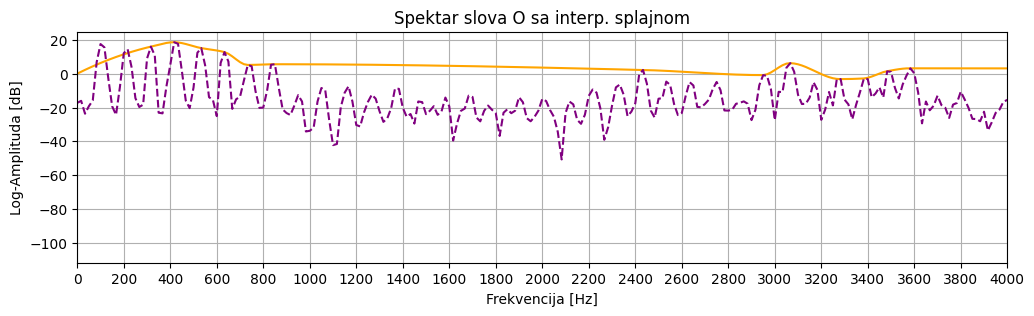

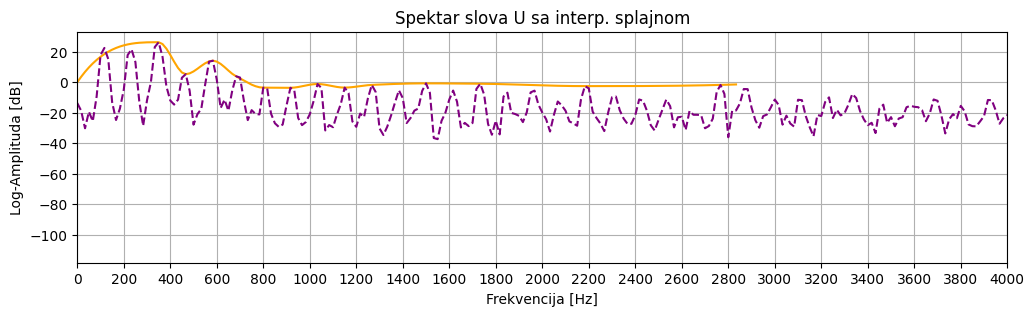

In [18]:
graph_interp_spline(data_proc, vowel='a')
graph_interp_spline(data_proc, vowel='e')
graph_interp_spline(data_proc, vowel='i')
graph_interp_spline(data_proc, vowel='o')
graph_interp_spline(data_proc, vowel='u')


Formanti F1, F2, F3 su prva tri najviša brijega na spektralnoj omotnici. Sljedeća funkcija traži te lokalne maksimume tj. formante tako da nađe tri najviša brijega te ta tri poreda po rastućoj frekvenciji.

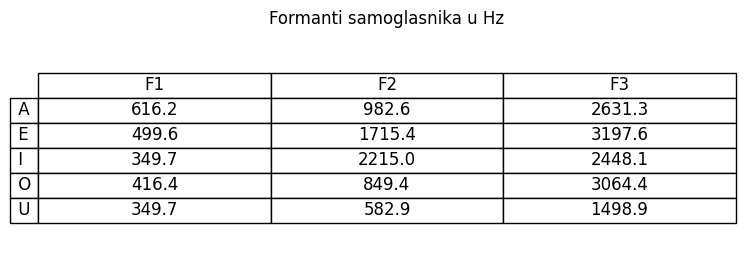

In [19]:
def find_formants(sig_data):
    spline, indices, spectrum, freqs = peak_interp_spline(sig_data, n=5)

    formants = []
    for i in range(5):
        spln_pts = spline[i](freqs[indices[0][0]: indices[0][-1]+5])
        dist = 200 / ((fs/2) / len(spectrum[i])) #Minimalna udaljenost izmedju vrhova
        pks, values = find_peaks(spln_pts, height=-1, distance=dist)
        pks = pks * ((fs/2) / len(spectrum[i]))
        
        points = np.array([pks, values['peak_heights']])
        sorted_points = points[:, points[1].argsort()[::-1]]
        frmnts = sorted_points[:, :3]
        frmnts = frmnts[:, frmnts[0].argsort()]
        formants.append(frmnts[0])
    return np.array(formants)

formants = np.round(find_formants(data_proc), 1)

def print_formant_table(formants, title = "Formanti samoglasnika u Hz"):
    col_labels = ['F1', 'F2', 'F3']
    row_labels = [' A ', ' E ', ' I ', ' O ', ' U ']

    fig,ax = plt.subplots(figsize=(6, 3))
    ax.axis("off")

    table = ax.table(cellText=formants,
                     colLabels=col_labels,
                     rowLabels=row_labels,
                     loc='center',
                     cellLoc='center')
    
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    plt.title(title)
    plt.show()

print_formant_table(formants)


Usporedba rezultata s prosjekom rezultata paketa Phonlab.

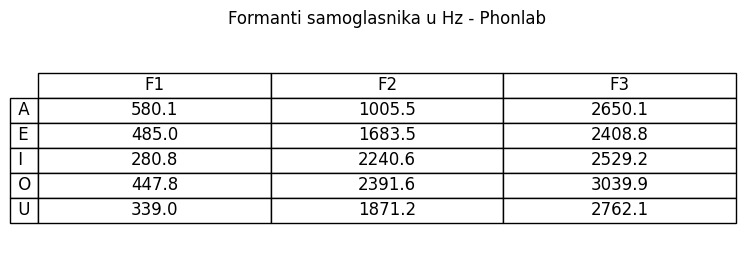

In [20]:
def phonlab_formants():
    formants = []
    for i in range(5):
        df = phon.track_formants(data_proc[i],fs=fs, method='ifc', speaker=0, order=12, quiet=True)
        formants.append([np.average(df["F1"]), np.average(df["F2"]), np.average(df["F3"])])
    return np.round(np.array(formants), 1)

print_formant_table(phonlab_formants(), title="Formanti samoglasnika u Hz - Phonlab")

Vidimo da su vrijednosti F1 sve relativno blizu (unutar 100Hz), vrijednosti F2 za A, E, I su isto blizu, ali za O,U se prilično razlikuju. Za F3 A, I, O su slični, E se ne podudara, ali promatranjem interpolacija iznad vidimo da je Phonlab F3 za E točniji, pošto se moj F3 nalazi na višoj frekv. moguće je da se radi o F4, F3 za samoglasnik U se razlikuju. 

### **3. Dio**: Vizualizacija i prepoznavanje


Raspršeni dijagram formanata F1 i F2 dobiveni mojim algoritmom.

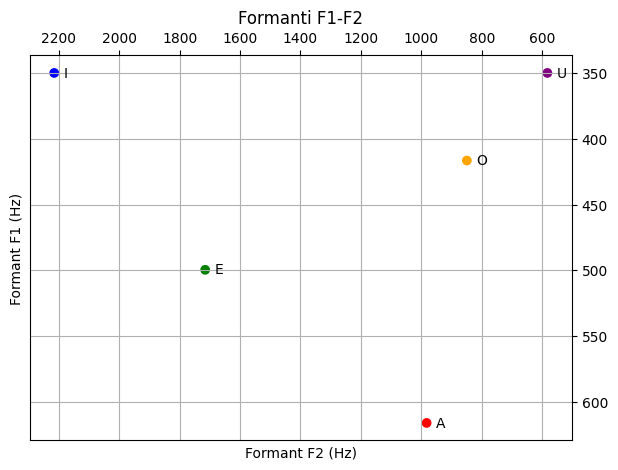

In [21]:
def formant_scatter_plot(formants):
    colors = np.array(["red","green","blue","orange","purple"])
    labels = np.array(["A", "E", "I", "O", "U"])
    x = formants[:, 1]
    y = formants[:, 0]

    fig,ax = plt.subplots(figsize=(7,5))
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.invert_xaxis()
    ax.invert_yaxis()

    ax.grid("on")
    ax.scatter(x, y, color=colors)

    ax.set_xlabel("Formant F2 (Hz)")
    ax.set_ylabel("Formant F1 (Hz)")

    for x_pos, y_pos, label in zip(x, y, labels):
        ax.annotate(label, xy=(x_pos, y_pos), xytext=(7, 0), textcoords='offset points', ha='left', va='center')

    plt.title("Formanti F1-F2")
    plt.show()

formant_scatter_plot(formants)

### Interpretacija


* Kojim se samoglasnicima točke grupiraju zajedno, a koji su izdvojeni?

Grubo gledano glasovi U i O su grupirani dok su A, E, I izdvojeni, O i U su relativno blizu iz nekoliko razloga, oba glasa nastaju u stražnjem dijelu usne šupljine sa zabačenim jezikom te oblik usna je okrugao kod oba glasa. Promatrajući grupiranost po osima, vidimo da su vrijednosti F1 za glasove O, U, I bliske, razlog je što ti glasovi nastaju u stražnjem dijelu usne šupljine te su dublji, za glasove A i E vrijednosti F1 su više jer nastaju u sredini usne šupljine. Promatrajući os F2, opet su glasovi O i U blizu jer je položaj F2 koreliran s oblikom usana, prilikom izgovaranja O i U imaju okrugao oblik usana, glas A ima ovalni oblik usana pa je F2 viši, glasovi E i I imaju široki oblik usana stoga oni imaju najviši F2.

* Koji samoglasnik ima najniži F1? Što to fizikalno znači (razmislite o otvoru usne šupljine)?

Samoglasnici I i U imaju najniži (začudo jednak) F1. Prilikom izgovora tih glasova usne su minimalno otvorene u usporedbi s glasom A koji ima najviši F1 te je čeljust opuštena i usne su otvorene. Nadalje, jezik kod I i U je na stražnjem dijelu usne šupljine te je malko udaljen od stražnjeg nepca time nastaje suženje kojom zrak prolazi i dolazi u "veliku" prednju šupljinu gdje titra nižom frekvencijom - skupljene usne rezultiraju većim otvaranjem usne šupljine.

* Što možete reći o položaju samoglasnika "I" u odnosu na "U"?

Vidimo da U i I dijele isti F1, ali F2 im je potpuno različit. Sličnost između F1 je prokomentirana u prošlom pitanju, različitost F2 je zbog oblika usana tijekom izgovaranja, naime prilikom glasa I usne su nam blizu jedna druge i raširene (poput osmjeha) time je suženje u usnoj šupljini veliko tj. zrak ima mali prorez za proći pa zato titra visokom frekvencijom, suprotno, prilikom izgovaranja glasa U su nam usne skupljene time je prorez za prolaz zraka dosta veći pa zrak sporije titra tj. frekvencija je niža.

### **4. Dio**: Sinteza samoglasnika

**Podzadatak 4.1**: Sinteza jednostavnim modelom "izvor-filter"

In [22]:
f0 = np.round(np.average(f0_list), 0)
print(f"Osnovna frekvencija f0 = {f0} Hz")

Osnovna frekvencija f0 = 113.0 Hz


Za funkcije izvora koristi se lanac impulsa ili zbir kosinusa.

In [23]:
def pulse_train(f0, T = 1, sr = 44100):
    sound = np.zeros(sr*T)
    
    interval = int(sr/f0)
    sound[::interval] = 1.0

    #Filter za naglasavanje - malo prosiri impuls
    a = [1, -0.95]  
    sound = lfilter([1], a, sound)
    
    return sound / np.max(np.abs(sound))

def cosine_train(f0, n = 10, T = 1, sr = 44100):
    t = np.arange(int(sr*T)) / sr
    sound = np.zeros_like(t)

    for i in range(1, n+1):
        sound += (1 / i) * np.cos(2*i*np.pi*f0*t)

    return sound / np.max(sound)

Kako zvuči generirani zvuk glasnica?

In [24]:
Audio(data=pulse_train(f0), rate=fs, normalize=False)

Pojasno-propusni IIR filter za oblikovanje formanata te funkcija koja primjenjuje kaskadu filtera na ulazni signal.

In [25]:
def formant_filter(F, BW, gain_db, sr = 44100):
    omega_0 = (2 * np.pi * F) / sr
    Q = F / BW

    gain = 10 ** (gain_db / 20)
    b, a = iirpeak(F, Q, fs=sr)
    
    return tf2sos(b * gain, a)

def formant_cascade_filter(signal, formants, out_gain_db=0, sr = 44100):
    sos = []
    for F, B, g in formants:
        sos.append(formant_filter(F, B, g, sr))
    
    sos = np.vstack(sos)

    out_gain = 10 ** (out_gain_db / 20)
    vowel = out_gain * sosfilt(sos, x=signal)

    if (np.max(np.abs(vowel)) >= 1):
        vowel = vowel / np.max(np.abs(vowel))

    return vowel

**Podzadatak 4.2**: Eksperimentiranje sa sintezom

Primjer sinteze samoglasnika A, E, I, O, U s formantima F1, F2, F3. Formanti F1, F2 su uzeti iz prve tablice dok F3 je iz prve tablice za A i I iz druge tablice za E, U te F3, za O niti jedna vrijednost ne daje dobar rezultat, promatranjem spektralne omotnice vidi se mali brijeg oko 2450 Hz koji algoritam nije pokupio (zbog male amplitude pa se uklopio sa šumom)  pa je to stavljeno za F3. (Glasovi su stavljeni u jedan zapis da se bolje čuje razlika između njih)

In [26]:
# Lista formanata u obliku (F_i, BW, gain_dB)
a_form = np.array([
    [616.2, 50, 20],    # F1
    [982.6, 80, 20],    # F2
    [2631.3, 120, 20]   # F3
])

e_form = np.array([
    [499.6, 50, 20],    
    [1715.4, 80, 20],   
    [2408.8, 80, 30]
])

i_form = np.array([
    [349.7, 50, 20],    
    [2215.0, 80, 20],   
    [2448.1, 100, 20]
])

o_form = np.array([
    [416.4, 70, 20],    
    [849.4, 100, 20],   
    [2450, 120, 20]
])

u_form = np.array([
    [349.7, 50, 20],   
    [582.9, 80, 20],  
    [2762, 120, 20]
])

vow_formant_data = np.array([a_form, e_form, i_form, o_form, u_form])

def play_vowels(vow_formant_data, pulsetrain):
    synth_vowels = []
    
    for i, form in enumerate(vow_formant_data):
        synth_vowels.append(formant_cascade_filter(pulsetrain, form, out_gain_db=5))
    synth_vowels = np.array(synth_vowels)
    
    sil = np.zeros(int(fs/4)) # Tisina od 0.25s
    return(np.concatenate([synth_vowels[0], sil,
                            synth_vowels[1], sil, 
                            synth_vowels[2], sil,
                            synth_vowels[3], sil, 
                            synth_vowels[4]]))
    
Audio(data=play_vowels(vow_formant_data, pulse_train(f0)), rate=44100, normalize=False, autoplay=False)

Originalni samoglasnici

In [27]:
original_vowels = np.concatenate([np.concatenate([data[i, 0:44100], np.zeros(int(fs/4))]) for i in range(5)])
Audio(data=original_vowels, rate=44100, normalize=True, autoplay=False)

Usporedba spektara originalnih i sintetiziranih samoglasnika. Za originalni je uzet spektar prednaglašenog kratkog prozora za bolje istjecanje viših frekvencija.

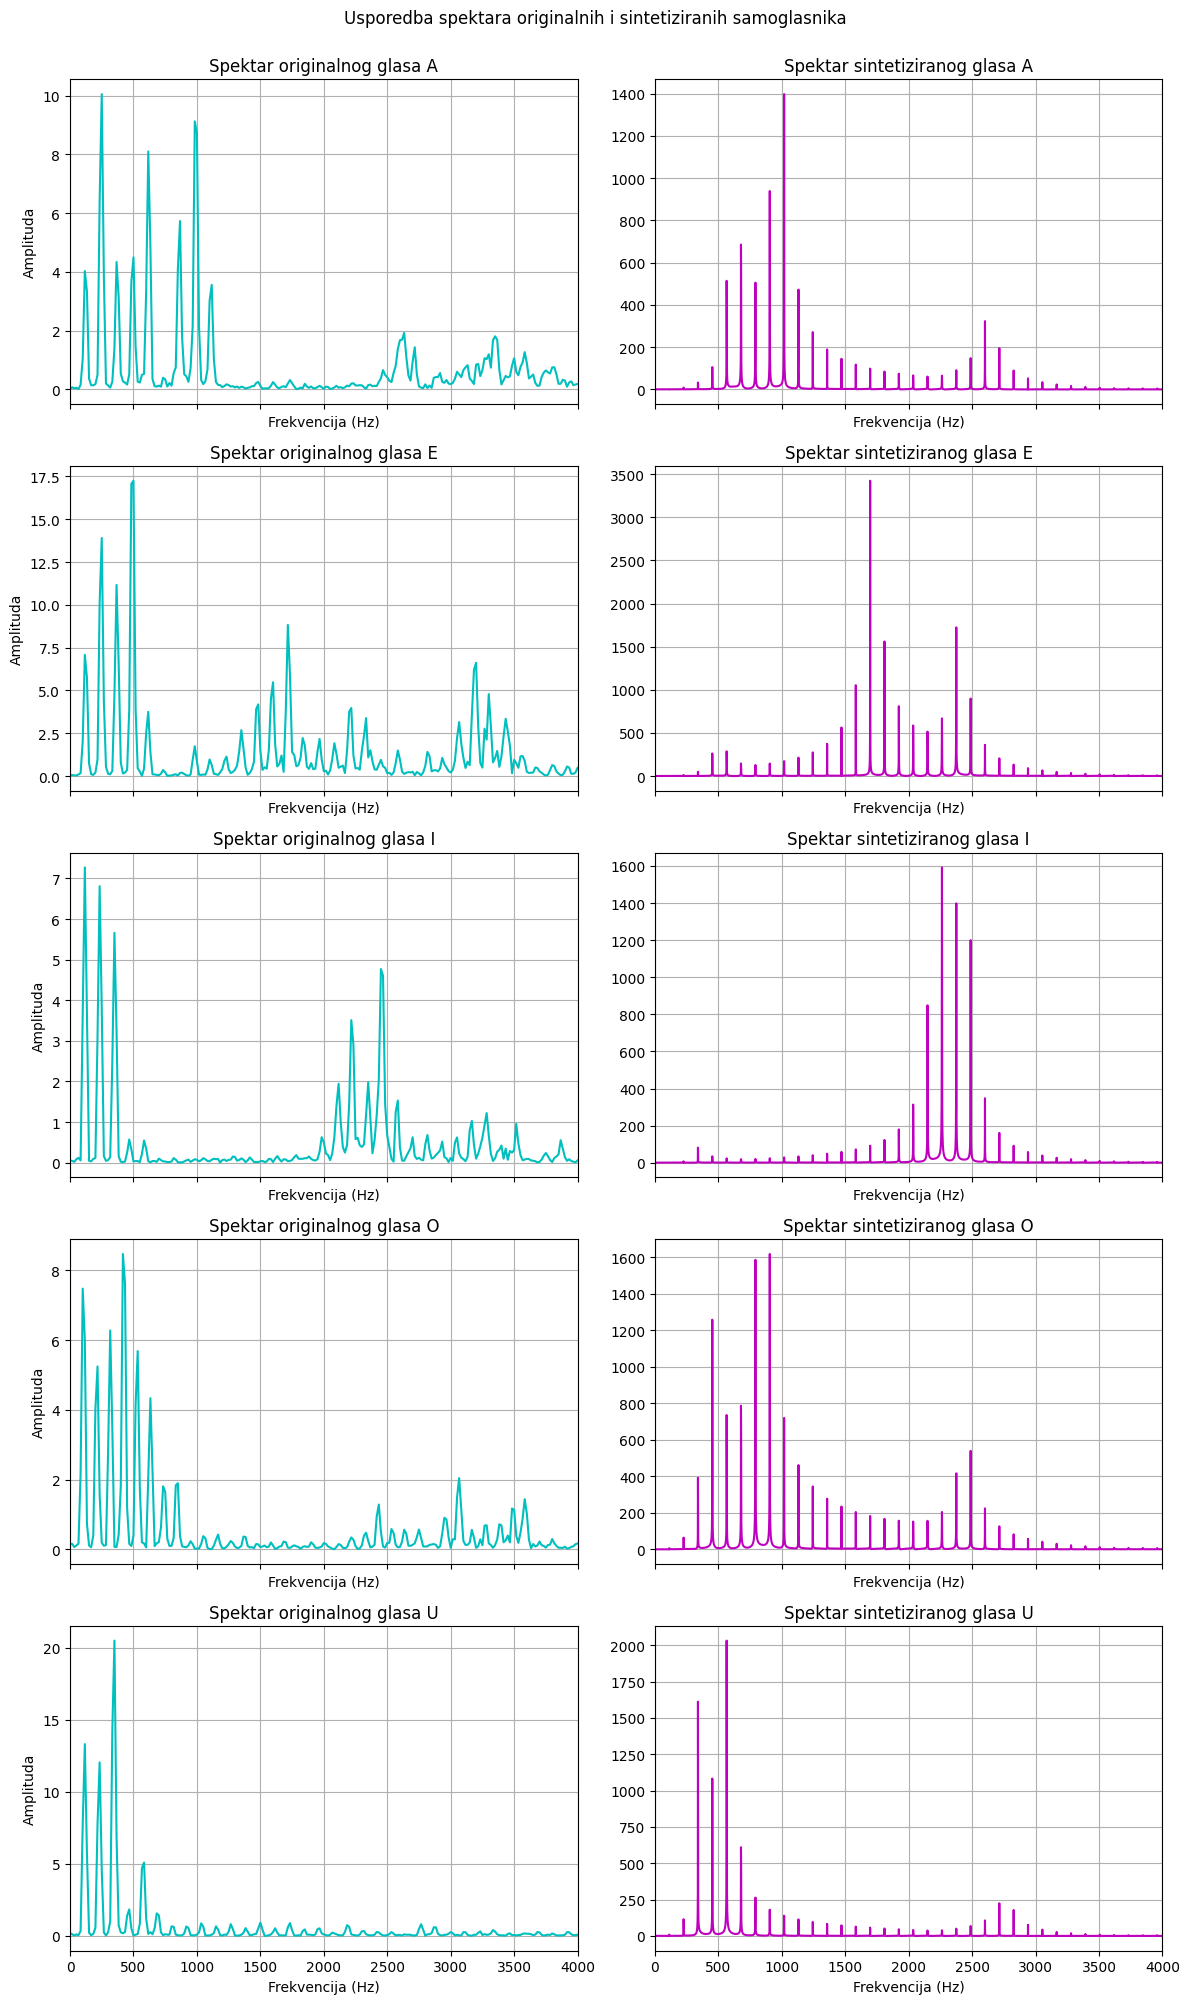

In [28]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 20), sharex='col')
dB = False #Staviti True za log prikaz

fig.suptitle("Usporedba spektara originalnih i sintetiziranih samoglasnika", y=1)

synth_vowels = []

for i, form in enumerate(vow_formant_data):
    synth_vowels.append(formant_cascade_filter(pulse_train(f0), form, out_gain_db=5))
synth_vowels = np.array(synth_vowels)

for i, ax in enumerate(ax):
    spec_orig = np.log10(np.abs(np.fft.rfft(data_proc[i]))) if dB else np.abs(np.fft.rfft(data_proc[i]))
    spec_synth = np.log10(np.abs(np.fft.rfft(synth_vowels[i]))) if dB else np.abs(np.fft.rfft(synth_vowels[i]))

    freqs_orig = np.linspace(0.,fs/2 , len(spec_orig))
    freqs_synth = np.linspace(0.,fs/2 , len(spec_synth))
    
    ax[0].set_xlim(0, 4000)
    ax[1].set_xlim(0, 4000)
    
    ax[0].grid("on")
    ax[1].grid("on")
    
    ax[0].plot(freqs_orig, spec_orig, color='c')
    ax[1].plot(freqs_synth, spec_synth, color='m')

    ax[0].set_title(f"Spektar originalnog glasa {vowels[i].capitalize()}")
    ax[1].set_title(f"Spektar sintetiziranog glasa {vowels[i].capitalize()}")

    ax[0].set_ylabel("Log-Amplituda") if dB else ax[0].set_ylabel("Amplituda")
    ax[0].set_xlabel("Frekvencija (Hz)")
    ax[1].set_xlabel("Frekvencija (Hz)")
plt.tight_layout()

U usporednom prikazu spektara jasno je da se oblici spektra okvirno podudaraju u područjima formanata, amplitude su različite zbog pojačanja filtera za sintezu (kod kaskade filtera filteri se primjenjuju serijski stoga nije lako moguće pojačati svaki formant zasebno, kad bi se svaki filter primjenio paralelno i na kraju svaki izlaz zbrojio tada bi se moglo to postići). U sintetiziranom dijelu nedostaju glavne harmonike f0 kao u originalu jer ih su ih filteri znatno prigušili - to pridodaje jasnoj razlici u zvuku. Formanti su puno jače izraženi u sintetiziranom spektru za razliku od ljudskom gdje su dosta slabije izraženi zbog raznih "prepreka i nepravilnosti" u vokalnom traktu.

Razlike u zvuku su izrazite, ali opet je moguće identificirati svaki samoglasnik što govori da formanti zaista nose većinu informacija o samoglasniku. Funkcija izvora je gruba aproksimacija stvarnog spektra glasnica te ona nije "lijepa" - sastavljena od čistih tonova stoga nam zvuči neprirodno. Jasno da se usna šupljina, utjecaj jezika i usana ne može opisati jednostavnim filterima. U ljudskom glasu ima jasno više od tri formanta te se oni mijenjaju u vremenu (zato je za analizu uzez kratki isječak glasa) stoga sintetizirani glas koj ima staične formante ne zvuči ljudski već robotski, jasno ljudski glas nikako nije statičan, već ima oscilacije u amplitudi (vibrato), niti je savršeno periodičan. Mnogo takvih razlika pridonosi složenosti ljudskom glasu za razliku od sintetiziranog glasa koji je jednostavan, konstantan te manjka nepravilnosti i kompleksnost ljudskog glasa. Također, ljudski glas je sniman što pridonosi nepravilnostima (šum, jeka i sl.)

* Eksperimentiranje s paramentrima

Promjena osnovne frekvencije f0 na 300 Hz

In [34]:
Audio(data=play_vowels(vow_formant_data, pulse_train(300)), rate=44100, normalize=False, autoplay=False)

Zvuk je postao puno viši što je očekivano jer je podignuta osnovna frekvencija, ali formanti nisu mijenjani pa prije formanta F1 postoji samo jedna ili dvije harmonike f0 pa se razlika slabo čuje, općenito ima manje harmonika (cca. 2.5 puta manja) pa one također dominiraju formantima, rezultat je teže razlikovanje samoglasnika. Laički rečeno zvuči kao da se govori kroz nos s jako povišenim glasom. Osobe s tako visokom f0 imaju znatno različite formante od mojih (muških) formanata.

Pomicanje položaja formanta - množenje formanta s faktorom 1.5

In [30]:

offset = np.ones_like(vow_formant_data)
for i in range(3):
    offset[:, i, 0] = 1.5

Audio(data=play_vowels(vow_formant_data * offset, pulse_train(f0)), rate=44100, normalize=False, autoplay=False)

Pomicanjem svih formanata u desno s istim faktorom utječe na visinu tona glasa - zvuči pomalo kao glas (robotskog) djeteta. Glasovi se mogu razaznati jer je "relativan položaj" (njihov omjer) formanata ostao isti.

Povećavanje širine pojasa (bandwith). Svaki pojas je proširen za 100Hz.

In [31]:
bw_offset = np.zeros_like(vow_formant_data)
for i in range(3):
    bw_offset[:, i, 1] = 100
    bw_offset[:, i, 2] = -7 # Malo smanjenje glasnoće

Audio(data=play_vowels(vow_formant_data + bw_offset, pulse_train(f0)), rate=44100, normalize=False, autoplay=False)

Proširenjem pojasa dolazi do slabljenja razlika između formanata stoga glasovi koji imaju neke bliske formante zvuče sličnije (npr. O i U te A i E). Rezultat koji je očekivan kod proširivanja pojasa je da glasovi zvuče prirodnije te prigušenije što ovdje nije slučaj vjerojatno zbog toga što je izvor niz impulsa koji zvuči izrazito isprekidano pa širina pojasa ne može puno pomoći.

Na internetu sam pronašao tzv. Rosenbergov glottalni puls koji bi trebao zvučati prirodnije. Taj puls ima različito vrijeme rasta i pada unutar perioda. Ispod se nalazi oblik tih pulseva.

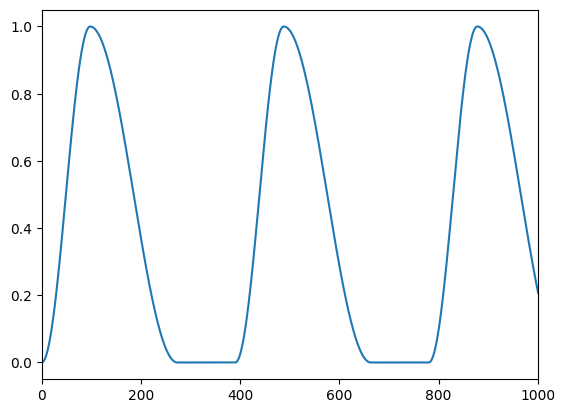

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def rosenberg_glottal(f0, fs=44100, T=1.0, T_rising_ratio=0.25, T_falling_ratio=0.45):
    t = np.arange(0, T, 1/fs)
    T0 = 1 / f0

    Tr = T_rising_ratio * T0
    Tf = T_falling_ratio * T0

    tau = np.mod(t, T0)

    g = np.zeros_like(t)

    rise = tau < Tr
    g[rise] = 0.5 * (1 - np.cos(np.pi * tau[rise] / Tr))

    fall = (tau >= Tr) & (tau < Tr + Tf)
    g[fall] = np.cos(np.pi * (tau[fall] - Tr) / (2 * Tf))**2

    return g


rg_source = rosenberg_glottal(f0)
plt.plot(rg_source)
plt.xlim(0, 1000)
plt.show()

Kako zvuče sintetizirani glasovi s ovim izvorom i proširenim pojasom? (Proširenje je smanjeno na 50Hz kako bi se manje stapali glasovi kao u prošlom slučaju)

In [33]:
bw_offset = np.zeros_like(vow_formant_data)
for i in range(3):
    bw_offset[:, i, 1] = 50
    bw_offset[:, i, 2] = 3 # Malo povećanje glasnoće

Audio(data=play_vowels(vow_formant_data + bw_offset, rg_source), rate=44100, normalize=False, autoplay=False)

Doista zvuči malo prirodnije i prigušenije, ovaj izvor nema tako "oštre" skokove stoga, uz proširenje pojasa, zvuči bolje nego prošli primjer, glas A je prigušeniji nego ostali - to se vjerojatno može poboljšati s boljim parametrima.

### Literatura

* https://numpy.org/doc/2.2/reference/index.html
* https://docs.scipy.org/doc/scipy/reference/index.html
* https://matplotlib.org/stable/api/index.html
* https://phonlab.readthedocs.io/en/
* https://en.wikipedia.org/wiki/Formant
* https://speechprocessingbook.aalto.fi/index.html
* https://www.fon.hum.uva.nl/david/ma_ssp/2007/rosenberg_JASA_1971.pdf
  
